<a href="https://colab.research.google.com/github/alexsalman/CSE247/blob/main/3D_CNN_FINE_TUNE_Saliency_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**3D Convolutional Neural Network**
######*I am using 3D Convolutional Neural Network to extract the temporal and spatial information which are merged slowly throughout the whole network.*

In [1]:
# required libraries
# !pip install keras
# !pip install tensorflow==2.8
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, Attention
from keras.layers import BatchNormalization, GlobalAveragePooling3D
from keras import regularizers
from PIL import Image
%matplotlib inline
print(tf.version.VERSION)
# https://bleedai.com/human-activity-recognition-using-tensorflow-cnn-lstm/
from keras import backend as K 
from keras import activations
# !pip install keras-vis
# !pip install https://github.com/raghakot/keras-vis/archive/master.zip
# !pip install keras==2.2.2
# !pip install tensorflow==1.14.0
# from vis.visualization import visualize_saliency
from vis.utils import utils
# !pip install tf-keras-vis tensorflow
from keras.layers.convolutional import Conv2D

2.8.0


In [2]:
# set Numpy, Python, and Tensorflow seeds to get consistent results on every execution
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
# mount dataset from google drive
drive.mount('/content/gdrive/', force_remount=True)
gdrive_path = '/content/gdrive' + '/My Drive/247/'
os.chdir(gdrive_path)
os.getcwd()

Mounted at /content/gdrive/


'/content/gdrive/My Drive/247'

In [4]:
# frame dimention
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
# frame number for each video (depth)
SEQUENCE_LENGTH = 16
# video dir path
DATASET_DIR = gdrive_path + 'Cropped_videos'
# labels of classes
CLASSES_LIST = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']

In [5]:
# image cropping
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [6]:
# https://medium.com/analytics-vidhya/video-preprocessor-and-augmentation-for-deep-learning-tasks-12dd3fcce868
def load_video(path, resize=(128, 128)):
    video_reader = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = video_reader.read()
            if not ret:
                  break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            black_frame = frame
            frames.append(frame)
    finally:
        video_reader.release()
    return np.array(frames) / 255.0

In [7]:
def create_dataset(state):
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name} {state}')
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            # create testing data
            if state == 'test':
                # get the mouse number
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                # get the mouse side (L or R)
                mouse_side = video_file_path.split(' ')[2].split('_')[1].split('-')[2]
                if mouse_number == 4 and mouse_side == 'L':
                    frames = load_video(video_file_path)
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
            # create validation data
            elif state == 'valid':
                # get the mouse number
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                # get the mouse side (L or R)
                mouse_side = video_file_path.split(' ')[2].split('_')[1].split('-')[2]
                if mouse_number == 4 and mouse_side == 'R':
                    frames = load_video(video_file_path)
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
            # create training data
            else:
                # get the mouse number
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                if mouse_number != 4:
                    frames = load_video(video_file_path)
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
    # Converting the list to numpy arrays
    features = np.asarray(features)
    # print(features)
    labels = np.array(labels)
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [8]:
# 6 mice for training, 2 mice for test and validation (one wound on each mice for test one for validation)
features_train, labels_train, video_files_paths_train = create_dataset('train')
features_test, labels_test, video_files_paths_test = create_dataset('test')
features_valid, labels_valid, video_files_paths_valid = create_dataset('valid')

Extracting Data of Class: hemostasis train
Extracting Data of Class: inflammatory train
Extracting Data of Class: proliferative train
Extracting Data of Class: maturation train
Extracting Data of Class: hemostasis test
Extracting Data of Class: inflammatory test
Extracting Data of Class: proliferative test
Extracting Data of Class: maturation test
Extracting Data of Class: hemostasis valid
Extracting Data of Class: inflammatory valid
Extracting Data of Class: proliferative valid
Extracting Data of Class: maturation valid


In [9]:
# one_hot_encoded_labels
labels_train = keras.utils.to_categorical(labels_train)
labels_test = keras.utils.to_categorical(labels_test)
labels_valid = keras.utils.to_categorical(labels_valid)

In [10]:
gdrive_path = '/content/gdrive' + '/My Drive/247/Saved_models'
os.chdir(gdrive_path)
os.getcwd()

'/content/gdrive/My Drive/247/Saved_models'

In [11]:
trained_Model = tf.keras.models.load_model('3DCNN_2022MayFriday13/fine_tuned_3d_cnn_2022_05_13__19_27_03/fine_tuned_3d_cnn_model___Date_Time_2022_05_13__19_27_03___Loss_0.891024112701416___Accuracy_0.7463235259056091.h5')

In [12]:
trained_Model.summary(line_length = 125)

Model: "sequential"
_____________________________________________________________________________________________________________________________
 Layer (type)                                           Output Shape                                      Param #            
 conv3d (Conv3D)                                        (None, 14, 126, 126, 32)                          2624               
                                                                                                                             
 max_pooling3d (MaxPooling3D)                           (None, 7, 63, 63, 32)                             0                  
                                                                                                                             
 dropout (Dropout)                                      (None, 7, 63, 63, 32)                             0                  
                                                                                                  

In [13]:
score = trained_Model.evaluate(features_test, labels_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')


Test loss: 0.8910241723060608 / Test accuracy: 0.7463235259056091


In [14]:
trained_Model.layers[11].activation = activations.linear
linear_model = utils.apply_modifications(trained_Model)

In [15]:
indices_to_visualize = [200]

(128, 128)


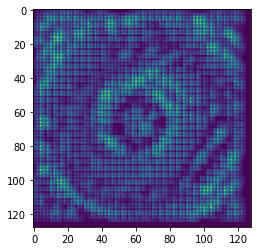

In [54]:
from socket import fromfd
# Visualize
from keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore([1])
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm
from tf_keras_vis.utils import normalize

yhat1 = trained_Model.predict(features_test)
pred = np.argmax(yhat1, axis=1)

saliency = Saliency(linear_model, clone=False)
saliency_map = saliency(score, features_test[0])
saliency_map = normalize(saliency_map)
print(saliency_map[0][0].shape)

# subprot_args = {
#    'nrows': 1,
#    'ncols': 4,
#    'figsize': (6, 3),
#    'subplot_kw': {'xticks': [], 'yticks': []}
# }
# f, ax = plt.subplots(**subprot_args)
# for i in range(len(saliency_map)):
#    ax[i].imshow(saliency_map[i], cmap='jet')
# plt.tight_layout()
plt.imshow(saliency_map[0][7])
plt.show()